In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize 
import gensim
import gensim.downloader as api
import string
import re
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from nltk.corpus import stopwords 
from fuzzywuzzy import fuzz
from sklearn import preprocessing
from numpy import dot
from numpy.linalg import norm
from gensim.models import Word2Vec, KeyedVectors
from scipy.cluster import  hierarchy

## Load pretrained Word2Vec and sample data

In [ ]:
#model = api.load("word2vec-google-news-300")

In [2]:
model_path = api.load("word2vec-google-news-300", return_path=True)

In [58]:
w2v = KeyedVectors.load_word2vec_format(model_path, binary= True)

In [59]:
# normalized model so we can use wmdistance later
w2v_norm = KeyedVectors.load_word2vec_format(model_path, binary= True)
w2v_norm.init_sims(replace=True)

In [1154]:
with open('../data/data.txt', 'r') as f: 
    data = f.readlines()
f.close()
data = [x.rstrip().lstrip().strip('\",') for x in data]
print (data)

['Marks and Spencers Ltd', 'M&S Limited', 'NVIDIA Ireland', 'SLOUGH SE12 2XY', '33 TIMBER YARD,LONDON, L1 8XY', '44 CHINA ROAD, KOWLOON, HONG KONG', 'XYZ 13423 / ILD', 'ABC/ICL/20891NC', 'HARDWOOD TABLE', 'PLASTIC BOTTLE', 'LONDON', 'HONG KONG', 'ASIA', 'JP Morgan & Chase Co.', 'ICNAO02312', 'TOYS', '5 Time Square, New York, NY 10036', 'COMPUTER PARTS', 'INTEL CORPORATION', 'INTEL CO', 'Ryland Group Inc.', 'Sabre Holdings Corp', 'Safeco Corp', '4CE0460D0G', 'Vero Beach, Florida', 'WINE', 'Microwave', 'Plastic container', 'Europe', 'Canada', 'HGU6UH3']


## Preprocess data

In [579]:
df = pd.DataFrame()
df['text'] = data

In [580]:
table = str.maketrans('', '', string.punctuation.replace('#', '').replace('&', ''))
stop_words = set(stopwords.words('english')) 
    # After trying different preprocessing combinations, I decided not to filter out stops words, 
    # and keept '#' and '&' since they can help defining a string in our specific case 
def get_tokens(x): 
    x = re.sub(r'\d', '#', x).lower()
    tokens = word_tokenize(x)
    tokens = [w.translate(table) for w in tokens]
    tokens = [x for x in tokens if x != '']
    return tokens

In [581]:
df['clean_token'] = df['text'].apply(lambda x: get_tokens(x))
df['clean_string'] = df['clean_token'].apply(lambda x: ' '.join(x))

## Get word2vec vectors from pretrained model

In [582]:
model_vocab = w2v.vocab

In [1338]:
# get vector per string
def get_vector(x):
    agg_vector = []
    for token in x: 
        if token in model_vocab: 
            v = w2v[token]  
        elif token.capitalize() in model_vocab:
            v = w2v[token.capitalize()] 
        else: 
            #print (token, 'NOT FOUND!')
            v = w2v['#'] # assign unknown words (usually random letters in a serial number) to # to skew the vector
        agg_vector.append(v)
    agg_vector = np.array(agg_vector)
    agg_vector = np.mean(agg_vector, axis = 0)
    return agg_vector

In [584]:
df['vecter_300'] = df['clean_token'].apply(lambda x: get_vector(x))

abcicl NOT FOUND!
icnao NOT FOUND!
hgu NOT FOUND!


## Add more features

In [654]:
# Adding word and character count, and a flag for possible company name
company_str = ['corporation', 'inc', 'co', 'corp', 'cooperatives', 'ltd', 'limited', 'company', \
               'lp', 'incorporated', 'international']
def get_word_cnt(x): 
    return len(x)

def get_char_cnt(x): 
    return len(''.join(x))

def get_company_flag(x): 
    if any(w in company_str for w in x): 
        return 1
    else: return 0 
        
df['word_count'] = df['clean_token'].apply(lambda x: get_word_cnt(x))
df['char_count'] = df['clean_token'].apply(lambda x: get_char_cnt(x))
df['company_str'] = df['clean_token'].apply(lambda x: get_company_flag(x))

In [655]:
def concat_features(row): 
    concat_list = np.array([row['word_count'], row['char_count'], row['company_str']])
    new_concat_list = np.append(row['vecter_300'], concat_list)
    return new_concat_list

In [656]:
df['new_feature_concat'] = df.apply(lambda row: concat_features(row), axis = 1)

## Normalize matrix

In [658]:
def scale_mat(vec_matrix,preprocess_type):
    if preprocess_type == 'MinMax':
        scale = preprocessing.MinMaxScaler().fit(vec_matrix)  
    if preprocess_type == 'Standard':
        scale = preprocessing.StandardScaler().fit(vec_matrix)
    vals = scale.transform(vec_matrix)
    return vals

vector_matrix = np.array(df['new_feature_concat'].tolist())
vector_matrix = scale_mat(vector_matrix, 'MinMax')
print ('vector size: ', vector_matrix.shape)

vector size:  (31, 303)


In [659]:
# PCA reduce dimensions
sklearn_pca = PCA(n_components = 2)
vals_pca = sklearn_pca.fit_transform(vector_matrix)

In [660]:
# Add 2D array to df 
df['2D'] = vals_pca.tolist()

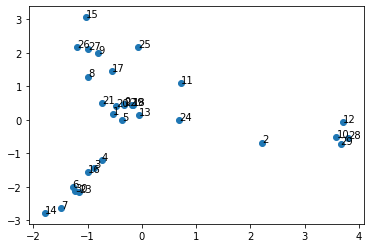

In [661]:
# plot
data2D = np.array(df['2D'].tolist())
n = df.index
plt.scatter(vals_pca[:,0], vals_pca[:,1])
for i, txt in enumerate(n):
    plt.annotate(txt, (vals_pca[i,0], vals_pca[i,1]))
plt.show()

We can see that there are some sort of patterns forming. Some examples are: 
<br> On far right there are locations: 10(LONDON), 12(ASIA), 28(Europ), and 29(Canada) 
<br> The center cluster is mostly companies: 0(Marks and Spencers Ltd), 1(M&S Limited), 21(Sabre Holdings Corp), 13(JP Morgan & Chase Co)
<br> The top part is mostly items, there are 8(HARDWOOD TABLE), 9(PLASTIC BOTTLE), 15(TOYS), 17(COMPUTER PARTS), 25(WINE), 26(microwave), 27(Plastic container)
<br> On bottom left there are serial numbers: 6(XYZ 13423 / ILD), 7(ABC/ICL/20891NC), 14(ICNAO02312), 23(4CE0460D0G), 30(HGU6UH3)

## Curious to see the clusters in a more mathematical way
<b> (Though hierarchy can't really be applied to massive data)

In [593]:
def print_clusters(df, cluster_col):
    cluster_dict = df.groupby(cluster_col)['text'].apply(list).to_dict()
    for k, v, in cluster_dict.items():
        print (k, v)
        print ()

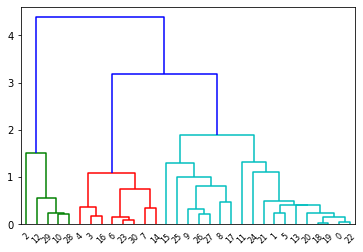

In [653]:
Z = hierarchy.linkage(vals_pca, method = "average", metric = 'euclidean')
plt.figure()
dn = hierarchy.dendrogram(Z)

Decent hierarchy graph, looks like 1.5 would be a good threshold

In [644]:
threshold = 1.5
C = hierarchy.fcluster(Z, threshold, criterion="distance")
labels = (C).tolist()
labels = ['cluster_'+str(s) for s in labels]

In [645]:
df['hierarchy_label'] = labels
print_clusters(df, 'hierarchy_label')

cluster_1 ['LONDON', 'ASIA', 'Europe', 'Canada']

cluster_2 ['NVIDIA Ireland']

cluster_3 ['SLOUGH SE12 2XY', '33 TIMBER YARD,LONDON, L1 8XY', 'XYZ 13423 / ILD', 'ABC/ICL/20891NC', 'ICNAO02312', '5 Time Square, New York, NY 10036', '4CE0460D0G', 'HGU6UH3']

cluster_4 ['Marks and Spencers Ltd', 'M&S Limited', '44 CHINA ROAD, KOWLOON, HONG KONG', 'HONG KONG', 'JP Morgan & Chase Co.', 'INTEL CORPORATION', 'INTEL CO', 'Ryland Group Inc.', 'Sabre Holdings Corp', 'Safeco Corp', 'Vero Beach, Florida']

cluster_5 ['HARDWOOD TABLE', 'PLASTIC BOTTLE', 'COMPUTER PARTS', 'WINE', 'Microwave', 'Plastic container']

cluster_6 ['TOYS']



Proceeding with these features for the second part

# Unique entity recognition (WIP)

In [ ]:
import scipy.spatial.distance as D
from sklearn import svm

## Load labeled data

In [1329]:
labeled = pd.read_excel('../data/Book1.xlsx') # test string INTEL CORPORATION

In [1330]:
labeled[labeled.Y==1] # I created some examples of equivalent entities 

,str_1,str_2,Y
8,Marks and Spencers Ltd,M&S Limited,1
18,LONDON,"London, United Kingdom",1
41,"VERO BEACH, FLORIDA","Vero Beach, FL",1
55,"5 Time Sqaure, New York, NY 10036","5 Time Sqaure, NY",1
68,Pepsi Co.,Pepsico,1
86,LONDON,"London, UK",1
111,"Los Angeles, CA","LA, California",1
124,United States of America,USA,1
149,ICNAO02312,IHB72910BU,1
151,"Bethlehem, Pennsylvania","Bethlehem, PA",1


In [1331]:
labeled.shape

(202, 3)

In [1325]:
# preprocess - input dataset with str_1 and str_2
def concat_features(row, col): 
    concat_list = np.array([row[col+'_word_count'], row[col+'_char_count'], row[col+'_company_flag']])
    new_concat_list = np.append(row[col+'_vector_300'], concat_list)
    return new_concat_list

# return a list of characteristics features, input data with str_1 and str2 
def get_char_features_labled(updated_df): 
    return_list = []
    for idx, row in updated_df.iterrows(): 
        append_list = []
        append_list.append(row['str_1_word_count']-row['str_2_word_count']) # word count difference
        append_list.append(row['str_1_char_count']-row['str_2_char_count']) # character count difference
        append_list.append(len(set(row['str_1_token']).intersection(set(row['str_2_token'])))) # common word
        append_list.append(fuzz.ratio(row['str_1_clean_string'], row['str_2_clean_string'])) # fuzz ratio
        append_list.append(fuzz.partial_ratio(row['str_1_clean_string'], row['str_2_clean_string'])) # fuzz partical
        append_list.append(fuzz.token_set_ratio(row['str_1_clean_string'], row['str_2_clean_string'])) # fuzz token set
        append_list.append(fuzz.partial_token_sort_ratio(row['str_1_clean_string'], row['str_2_clean_string']))
        append_list.append(fuzz.token_sort_ratio(row['str_1_clean_string'], row['str_2_clean_string']))
        return_list.append(append_list)
    return return_list

# return a list of distance features, input data with str_1 and str2 after normalization 
def get_dist_features_labeled(updated_df):
    v1 = np.array(updated_df['str_1_feature_concat'].tolist())
    v2 = np.array(updated_df['str_2_feature_concat'].tolist())
    return_list = []
    for i in range (v1.shape[0]): 
        append_list = []
        if v1[i].sum()==0 or v2[i].sum()==0: 
            print (updated_df.iat[i,0])
        append_list.append(D.cosine(v1[i], v2[i]))
        append_list.append(D.euclidean(v1[i], v2[i]))
        append_list.append(D.cityblock(v1[i], v2[i]))
        append_list.append(D.minkowski(v1[i], v2[i]))
        append_list.append(D.braycurtis(v1[i], v2[i]))
        append_list.append(D.canberra(v1[i], v2[i]))
        append_list.append(D.chebyshev(v1[i], v2[i]))
        return_list.append(append_list)
    return return_list

# concat and normlize X 
def process_X(c_v, d_v): 
    return_list = []
    for i in range(len(c_v)): 
        return_list.append(c_v[i]+d_v[i])
    mat = np.array(return_list)
    mat = scale_mat(mat, 'MinMax')
    return mat

def process_df(labeled_df):
    for col in ['str_1', 'str_2']: 
        labeled_df[col+'_token'] = labeled_df[col].apply(lambda x: get_tokens(x))
        labeled_df[col+'_clean_string'] = labeled_df[col+'_token'].apply(lambda x: ' '.join(x))
        labeled_df[col+'_vector_300'] = labeled_df[col+'_token'].apply(lambda x: get_vector(x))
        labeled_df[col+'_word_count'] = labeled_df[col+'_token'].apply(lambda x: get_word_cnt(x))
        labeled_df[col+'_char_count'] = labeled_df[col+'_token'].apply(lambda x: get_char_cnt(x))
        labeled_df[col+'_company_flag'] = labeled_df[col+'_token'].apply(lambda x: get_company_flag(x))
        labeled_df[col+'_feature_concat'] = labeled_df.apply(lambda row: concat_features(row, col), axis = 1)
    char_features = get_char_features_labled(labeled_df)
    dist_features = get_dist_features_labeled(labeled_df)
    # Got features, now concat and normalize
    labeled_df['X'] = process_X(char_features, dist_features).tolist()
    return labeled_df


In [1342]:
# Train a simple SVM 
labeled_df = process_df(labeled)
X_train = np.array(labeled_df['X'].tolist())
Y_train = labeled_df['Y'].values
clf = svm.SVC(probability = True)
clf.fit(X_train, Y_train)

SVC(probability=True)

Now test the classifier with new strings 

In [1335]:
# current data points 
data_inventory = labeled['str_1'].unique()

In [1350]:
# TESTING_STR_TRUE: There should be an equivalent entity in the data inventory 
TESTING_STR_TRUE = ['INTEL CO', 'IBM Corporation', 'SF, California', 'Shanghai, China', \
                    'Charlotte, North Carolina', 'Chicago, IL', 'Washington, District of Columbia', \
                    'Seoul, SK', 'GYU671A3']
# TESTING_STR_FALSE: They should NOT be groupped with any entity 
TESTING_STR_FALSE = ['Apple Inc.', 'Microsoft Corporation', 'Palm Beach, FL', 'Toronto, Canada', \
                     'Austin, TX', 'PwC LLP']

In [1351]:
for testing_str in TESTING_STR_TRUE: 
    new_df = pd.DataFrame({'str_1': data_inventory.tolist()})
    new_df['str_2'] = testing_str
    new_df = process_df(new_df)
    X_test = np.array(new_df['X'].tolist())
    P = clf.predict(X_test)
    new_df['clf'] = P.tolist()
    entity_list = new_df[new_df.clf==1]['str_1'].tolist()
    print (testing_str, ':', entity_list)

INTEL CO : ['Pepsi Co. ', 'INTEL CORPORATION']
IBM Corporation : ['INTEL CORPORATION', 'IBM Corp.']
SF, California : ['VERO BEACH, FLORIDA', 'Los Angeles, CA', 'INTEL CORPORATION', 'San Francisco, CA', 'Charlotte, NC', 'Chicago, Illinois']
Shanghai, China : ['San Francisco, CA', 'Shanghai, CN']
Charlotte, North Carolina : ['Charlotte, NC']
Chicago, IL : ['Chicago, Illinois']
Washington, District of Columbia : ['United States of America', 'Washington, D.C.']
Seoul, SK : ['Seoul, South Korea']
GYU671A3 : ['5 Time Sqaure, New York, NY 10036', 'ICNAO02312', '9012VU/38O']


In [1352]:
for testing_str in TESTING_STR_FALSE: 
    new_df = pd.DataFrame({'str_1': data_inventory.tolist()})
    new_df['str_2'] = testing_str
    new_df = process_df(new_df)
    X_test = np.array(new_df['X'].tolist())
    P = clf.predict(X_test)
    new_df['clf'] = P.tolist()
    entity_list = new_df[new_df.clf==1]['str_1'].tolist()
    print (testing_str, ':', entity_list)

Apple Inc. : ['Pepsi Co. ', 'Los Angeles, CA', 'RYLAND GROUP INC.', 'San Francisco, CA', 'Charlotte, NC']
Microsoft Corporation : ['INTEL CORPORATION']
Palm Beach, FL : ['VERO BEACH, FLORIDA']
Toronto, Canada : ['LONDON', 'VERO BEACH, FLORIDA', 'Los Angeles, CA', 'INTEL CORPORATION', 'San Francisco, CA', 'Boston, Massachusetts', 'Charlotte, NC', 'Chicago, Illinois', 'Washington, D.C.', 'Seoul, South Korea']
Austin, TX : ['ASIA', 'INTEL CORPORATION', 'Boston, Massachusetts', 'IBM Corp.', 'Charlotte, NC', 'Chicago, Illinois', 'Washington, D.C.']
PwC LLP : ['ICNAO02312', 'Ernst & Young LLP', 'cell phone']


### Archive

In [687]:
# Warp - Preprocess and get vector features (303,), return dictionary 
def get_feature_vector_303(string_input): 
    new_string_dict = { i : '' for i in df.columns}
    token = get_tokens(string_input)
    word_vec_google = get_vector(token)
    word_cnt = get_word_cnt(token)
    char_cnt = get_char_cnt(token)
    com_flag = get_company_flag(token)
    extra_features = np.array([word_cnt, char_cnt, com_flag])
    v = np.append(word_vec_google, extra_features)
    
    new_string_dict['text'] = string_input
    new_string_dict['clean_token'] = token
    new_string_dict['clean_string'] = ' '.join(token)
    new_string_dict['vecter_300'] = word_vec_google
    new_string_dict['word_count'] = word_cnt
    new_string_dict['char_count'] = char_cnt
    new_string_dict['company_str'] = com_flag
    new_string_dict['new_feature_concat'] = v
    #v = scale_mat(v.reshape(-1,1),'MinMax')
    return new_string_dict

In [1114]:
def scaler_for_df(df, scale_type): 
    df_array = np.array(df['new_feature_concat'].tolist())
    df_array = scale_mat(df_array,scale_type)
    return df_array

In [749]:
df.head(2)

,text,clean_token,vecter_300,word_count,char_count,company_str,new_feature_concat,2D,clean_string
0,Marks and Spencers Ltd,"[marks, and, spencers, ltd]","[-0.081870556, -0.028320312, -0.05102539, 0.10...",4,19,1,"[-0.08187055587768555, -0.0283203125, -0.05102...","[-0.3339800956502091, -0.35841218689219334]",marks and spencers ltd
1,M&S Limited,"[m, &, s, limited]","[-0.15039062, 0.09075928, -0.11743164, 0.13623...",4,10,1,"[-0.150390625, 0.09075927734375, -0.1174316406...","[-0.5162413962301977, -0.026243635885206534]",m & s limited


In [1054]:
test_string = 'London United Kingdom'
test_dict = get_feature_vector_303(test_string)

In [1055]:
df = df.append(test_dict, ignore_index=True)

In [1060]:
# return a list of characteristics features
def get_char_features(updated_df, new_string_dict): 
    return_list = []
    for idx, row in updated_df.iterrows(): 
        append_list = []
        append_list.append(row['word_count']-new_string_dict['word_count']) # word count difference
        append_list.append(row['char_count']-new_string_dict['char_count']) # character count difference
        append_list.append(len(set(row['clean_token']).intersection(set(new_string_dict['clean_token'])))) # common word
        append_list.append(fuzz.ratio(row['clean_string'], new_string_dict['clean_string'])) # fuzz ratio
        append_list.append(fuzz.partial_ratio(row['clean_string'], new_string_dict['clean_string'])) # fuzz partical
        append_list.append(fuzz.token_set_ratio(row['clean_string'], new_string_dict['clean_string'])) # fuzz token set
        return_list.append(append_list)
    return return_list

In [1057]:
vector_matrix = np.array(df['new_feature_concat'].tolist())
vector_matrix = scale_mat(vector_matrix, 'MinMax')
vals_pca = sklearn_pca.fit_transform(vector_matrix)
df['2D'] = vals_pca.tolist()

In [1058]:
# return s list of distance features
# input df after appeding the new string because need to do PCA 
def get_dist_features(updated_df): 
    new_vec = updated_df.tail(1)['2D'].to_numpy()[0]
    old_vec = updated_df['2D']
    return_list = []
    for v in old_vec: 
        #print (updated_df.iat[i,0], i)
        v = np.array(v)
        append_list = []
        append_list.append(D.cosine(v, new_vec))
        append_list.append(D.euclidean(v, new_vec))
        append_list.append(D.cityblock(v, new_vec))
        append_list.append(D.minkowski(v, new_vec))
        return_list.append(append_list)
    return return_list

In [1061]:
char_v = get_char_features(df, test_dict)
dist_v = get_dist_features(df)

In [1062]:
# concat and normlize X 
def process_X(c_v, d_v): 
    return_list = []
    for i in range(len(c_v)): 
        return_list.append(c_v[i]+d_v[i])
    mat = np.array(return_list)
    mat = scale_mat(mat, 'MinMax')
    return mat

In [1069]:
# update training df
train_df = pd.DataFrame(columns = ['str_1', 'str_2', 'X', 'Y'])
train_df['str_1'] = df['text']
train_df['str_2'] = test_string

In [1070]:
X = process_X(char_v, dist_v)

In [1071]:
df.shape, train_df.shape

((34, 9), (34, 4))

In [1072]:
train_df['X'] = X.tolist()

In [1075]:
# label data
train_df['Y'] = 0
train_df.iat[10,3] = 1
train_df.iat[33,3] = 1

In [1077]:
train_df_2 = train_df

In [1052]:
train_df_1 = train_df

In [1078]:
all_train = pd.concat([train_df_1, train_df_2])

In [1087]:
X = np.array(all_train['X'].tolist())

In [1088]:
X.shape

(67, 10)

SVC()

In [1035]:
train_df.shape

(33, 5)

In [1115]:
# try out the classifier 
try_string = 'vb, florida'
try_dict = get_feature_vector_303(try_string)
try_df = df.append(try_dict, ignore_index=True)

#vector_matrix = np.array(try_df['new_feature_concat'].tolist())
#vector_matrix = scale_mat(vector_matrix, 'MinMax')
vector_matrix = scaler_for_df(try_df, 'MinMax')
vals_pca = sklearn_pca.fit_transform(vector_matrix)

try_df['2D'] = vals_pca.tolist()
try_char_v = get_char_features(try_df, test_dict)
try_dist_v = get_dist_features(try_df)
try_X = process_X(try_char_v, try_dist_v)

print (try_X.shape)

new_train = pd.DataFrame()
new_train['str_1'] = try_df['text']
new_train['str_2'] = try_string


(35, 10)


In [1104]:
P = clf.predict(try_X)

In [1105]:
new_train['clf'] = P.tolist()

In [838]:
'''
for idx, row in my_df.iterrows(): 
    my_dict = row.to_dict()
    character_list = []
    character_list.append(my_dict['word_cnt']-test_w_cnt) 
    character_list.append(my_dict['char_cnt']-test_c_cnt) 
    character_list.append(len(set(my_dict['clean_token']).intersection(set(test_token)))) # number of common word
    character_list.append(fuzz.ratio(my_dict['clean_string'], test_clean_string)) # fuzz ratio
    character_list.append(fuzz.partial_ratio(my_dict['clean_string'], test_clean_string)) # fuzz partical
    character_list.append(fuzz.token_set_ratio(my_dict['clean_string'], test_clean_string))
    character_list.append(fuzz.token_sort_ratio(my_dict['clean_string'], test_clean_string))
    character_list.append(fuzz.partial_token_set_ratio(my_dict['clean_string'], test_clean_string))
    character_list.append(fuzz.partial_token_sort_ratio(my_dict['clean_string'], test_clean_string))
    print (character_list)
'''

"\nfor idx, row in my_df.iterrows(): \n    my_dict = row.to_dict()\n    character_list = []\n    character_list.append(my_dict['word_cnt']-test_w_cnt) \n    character_list.append(my_dict['char_cnt']-test_c_cnt) \n    character_list.append(len(set(my_dict['clean_token']).intersection(set(test_token)))) # number of common word\n    character_list.append(fuzz.ratio(my_dict['clean_string'], test_clean_string)) # fuzz ratio\n    character_list.append(fuzz.partial_ratio(my_dict['clean_string'], test_clean_string)) # fuzz partical\n    character_list.append(fuzz.token_set_ratio(my_dict['clean_string'], test_clean_string))\n    character_list.append(fuzz.token_sort_ratio(my_dict['clean_string'], test_clean_string))\n    character_list.append(fuzz.partial_token_set_ratio(my_dict['clean_string'], test_clean_string))\n    character_list.append(fuzz.partial_token_sort_ratio(my_dict['clean_string'], test_clean_string))\n    print (character_list)\n"

In [515]:
# return a matrix of all kinds of distances 
def get_all_dist(v1, v2): 
    dist_list = []
    dist_list.append(D.cosine(v1, v2))
    dist_list.append(D.euclidean((v1, v2)))
    return np.array(dist_list)

In [403]:
get_cosine_dist(init_vector, test_vector)

(303, 1)


0.018331223903671368

In [333]:

a = df.iloc[0,3]
b = df.iloc[1,3]
cos_sim = dot(a, b)/(norm(a)*norm(b))

In [334]:
cos_sim

0.8627565141838561

In [ ]:
df.iloc[2,0]

In [ ]:
from scipy import spatial

result = 1-spatial.distance.cosine(a, b)

In [ ]:
print (w2v.distance('corporation', 'co'))
print (w2v.wmdistance('corporation', 'co'))
print (w2v_norm.distance('corporation', 'co'))
print (w2v_norm.wmdistance('corporation', 'co'))
'''
def compute_similarity(s1, s2):
    return 1.0 - (0.01 * max(fuzz.ratio(s1, s2),fuzz.token_sort_ratio(s1, s2),fuzz.token_set_ratio(s1, s2)))
compute_similarity('INTELCORPORATION', 'INTELCO')
'''

In [ ]:
# add distance 
def get_distance(v1, v2): 
    return w2v.distance(a, b)

# add Word Mover's Distance
def get_WMD(v1, v2): 
    return w2v_norm.wmdistance(a, b)

def get_word_delta(tokens_1, tokens_2): 
    return 

In [ ]:
def dist_metric(a, b):
    sim = np.isnan(dot(a, b)/(norm(a)*norm(b)))
    if sim == False:
        return dot(a, b)/(norm(a)*norm(b))